# Polynomial Regression

We will now implement polynomial regression wherein we will try to fit the polynomial function on the given dataset.

$$ Y(x) = a + bx + cx^2 + dx^3 ........$$
This is a general polynomial function we used to fit the input data. 
We choose some polynomial of degree n to fit the data.

**Enough talk. Let's move to the implementation part.**

We will use the dataset downloaded from kaggle about Car price. But first let's import the required libraries for the model.


In [1]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import torch.nn as nn
import torch
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from torch.utils.data import DataLoader,Dataset
from torchmetrics import R2Score

In [3]:
data = pd.read_csv('CarPrice_Assignment.csv')
data.columns
price = data['price']

In [4]:
data.head(10)

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.000
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.000
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.000
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.000
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.000
5,6,2,audi fox,gas,std,two,sedan,fwd,front,99.8,...,136,mpfi,3.19,3.40,8.5,110,5500,19,25,15250.000
6,7,1,audi 100ls,gas,std,four,sedan,fwd,front,105.8,...,136,mpfi,3.19,3.40,8.5,110,5500,19,25,17710.000
7,8,1,audi 5000,gas,std,four,wagon,fwd,front,105.8,...,136,mpfi,3.19,3.40,8.5,110,5500,19,25,18920.000
8,9,1,audi 4000,gas,turbo,four,sedan,fwd,front,105.8,...,131,mpfi,3.13,3.40,8.3,140,5500,17,20,23875.000
9,10,0,audi 5000s (diesel),gas,turbo,two,hatchback,4wd,front,99.5,...,131,mpfi,3.13,3.40,7.0,160,5500,16,22,17859.167


For now we will only use continuous variable for the prediction of the car prices.

In [5]:
data = data[['wheelbase', 'enginesize', 'carlength', 'carwidth', 'carheight', 'curbweight', 'boreratio', 'stroke', 'compressionratio', 'horsepower', 'peakrpm', 'citympg',  'highwaympg', 'price']]

data.head(10)

,wheelbase,enginesize,carlength,carwidth,carheight,curbweight,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,88.6,130,168.8,64.1,48.8,2548,3.47,2.68,9.0,111,5000,21,27,13495.000
1,88.6,130,168.8,64.1,48.8,2548,3.47,2.68,9.0,111,5000,21,27,16500.000
2,94.5,152,171.2,65.5,52.4,2823,2.68,3.47,9.0,154,5000,19,26,16500.000
3,99.8,109,176.6,66.2,54.3,2337,3.19,3.40,10.0,102,5500,24,30,13950.000
4,99.4,136,176.6,66.4,54.3,2824,3.19,3.40,8.0,115,5500,18,22,17450.000
5,99.8,136,177.3,66.3,53.1,2507,3.19,3.40,8.5,110,5500,19,25,15250.000
6,105.8,136,192.7,71.4,55.7,2844,3.19,3.40,8.5,110,5500,19,25,17710.000
7,105.8,136,192.7,71.4,55.7,2954,3.19,3.40,8.5,110,5500,19,25,18920.000
8,105.8,131,192.7,71.4,55.9,3086,3.13,3.40,8.3,140,5500,17,20,23875.000
9,99.5,131,178.2,67.9,52.0,3053,3.13,3.40,7.0,160,5500,16,22,17859.167


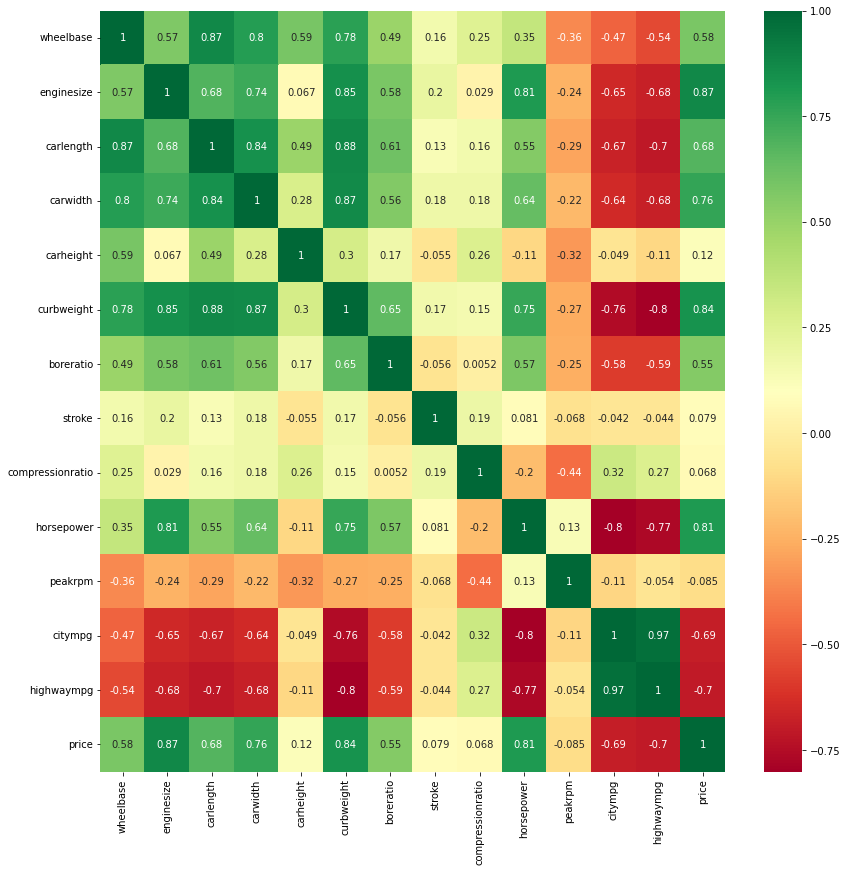

In [6]:
corr_matrix = data.corr()
corr_features = corr_matrix.index
plt.figure(figsize=(14,14))
g=sns.heatmap(data[corr_features].corr(),annot=True,cmap="RdYlGn")

As we can see from the above heatmap,We will select the wheelbase, enginesize, carlength, carwidth, curbweight, boreratio,horsepower,citympg,highwaympg as our variables as they depend mostly on the price.

In [7]:
data = data[['wheelbase','enginesize','carlength','carwidth','curbweight','boreratio','horsepower','citympg','highwaympg']]
vif = pd.DataFrame()
vif["features"] = data.columns
vif["vif_Factor"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
print(vif)

     features   vif_Factor
0   wheelbase  1744.674341
1  enginesize    55.004396
2   carlength  1753.383425
3    carwidth  1675.423446
4  curbweight   272.489943
5   boreratio   268.333335
6  horsepower    50.574346
7     citympg   402.912834
8  highwaympg   498.250718


In [8]:
data = data.drop(['carlength', 'carwidth'],axis = 1)
vif = pd.DataFrame()
vif["features"] = data.columns
vif["vif_Factor"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
print(vif)

     features  vif_Factor
0   wheelbase  471.627057
1  enginesize   53.662821
2  curbweight  241.469053
3   boreratio  238.324342
4  horsepower   38.150797
5     citympg  367.466091
6  highwaympg  441.420946


In [9]:
data = data.drop(['highwaympg'],axis = 1)
vif = pd.DataFrame()
vif["features"] = data.columns
vif["vif_Factor"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
print(vif)

     features  vif_Factor
0   wheelbase  461.577914
1  enginesize   52.740447
2  curbweight  225.315831
3   boreratio  230.592066
4  horsepower   33.627869
5     citympg   43.600660


we will use the variables wheelbase, enginesize, curbweight, boreratio, horsepower and citympg to find the price.

Text(0, 0.5, 'price')

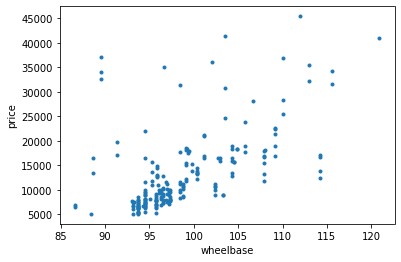

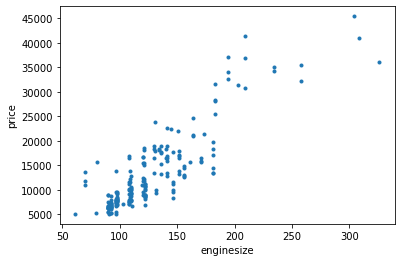

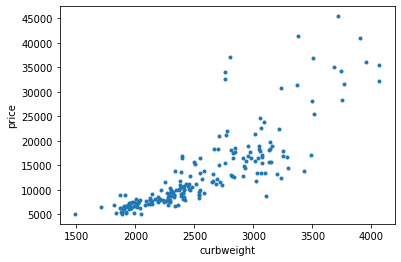

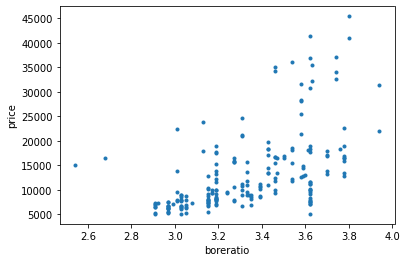

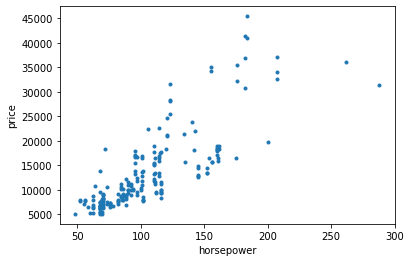

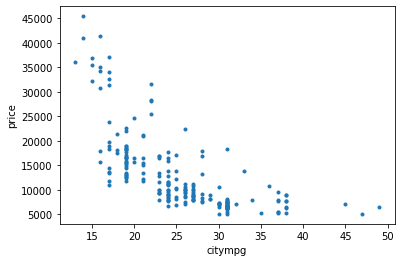

In [10]:
plt.plot(data['wheelbase'],price,'.')
plt.xlabel('wheelbase')
plt.ylabel('price')

plt.figure()
plt.plot(data['enginesize'],price,'.')
plt.xlabel('enginesize')
plt.ylabel('price')

plt.figure()
plt.plot(data['curbweight'],price,'.')
plt.xlabel('curbweight')
plt.ylabel('price')

plt.figure()
plt.plot(data['boreratio'],price,'.')
plt.xlabel('boreratio')
plt.ylabel('price')

plt.figure()
plt.plot(data['horsepower'],price,'.')
plt.xlabel('horsepower')
plt.ylabel('price')

plt.figure()
plt.plot(data['citympg'],price,'.')
plt.xlabel('citympg')
plt.ylabel('price')

The graph of price vs enginesize, curbweight, horsepower and boreratio, wheelbase is quadratic while the graph of price vs citympg is of degree -2.

In [11]:
enginesize2  = data['enginesize']**2
curbweight2 = data['curbweight']**2
horsepower2 = data['horsepower']**2
boreratio2 = data['boreratio']**2
citympg2 = 1/(data['citympg']**2)
citympg1 = 1/data['citympg']

In [12]:
features = pd.concat([data, enginesize2, curbweight2, horsepower2, boreratio2, citympg1, citympg2],axis = 1)

In [13]:
# Now we will define the polynomial regression model disguised as a linear regression model.

class Polynomial_regression(nn.Module):
    def __init__(self):
      super(Polynomial_regression, self).__init__()
      self.linear = nn.Linear(12,1, bias = True)
    def forward(self,x):
      output = self.linear(x)
      return output

In [14]:
# Giving values to the hyperparameters of the model

lr = 0.001
epochs = 5000
model = Polynomial_regression()
batch_size = 100
train_loss = []

In [15]:
features = torch.tensor(features.values.astype('float32'))
price = torch.tensor(price.values.astype('float32'))

In [16]:
# Time to make a custom dataset and dataloader

class Custom_Dataset(Dataset):
  def __init__(self,x,y):
    self.x = x
    self.y = y

  def __len__(self):
    return(len(self.y))

  def __getitem__(self,idx):
    return self.x[idx],self.y[idx]

dataset = Custom_Dataset(features, price)
dataloader = DataLoader(dataset,batch_size,shuffle = True)

In [17]:
# Now we will define the optimizer as well as the loss fucntion 
optimizer = torch.optim.Adam(model.parameters(),lr=0.001,betas=(0.9,0.999),eps=1e-08,weight_decay=0,amsgrad=False)
loss = nn.MSELoss()

In [18]:
for epoch in range(epochs):
  for batch_idx,(x,y) in enumerate(dataloader):
    optimizer.zero_grad()
    y_pred = model(x)
    mseloss = loss(y_pred,y)
    print("For {}th epoch and {}th batch, the error is {}".format(epoch+1,batch_idx+1,mseloss))
    mseloss.backward()
    optimizer.step()
    train_loss.append(mseloss.detach().numpy())

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Streaming output truncated to the last 5000 lines.
For 3334th epoch and 2th batch, the error is 85992352.0
For 3334th epoch and 3th batch, the error is 10180441.0
For 3335th epoch and 1th batch, the error is 82357280.0
For 3335th epoch and 2th batch, the error is 80256424.0
For 3335th epoch and 3th batch, the error is 178518208.0
For 3336th epoch and 1th batch, the error is 79666680.0
For 3336th epoch and 2th batch, the error is 83924232.0
For 3336th epoch and 3th batch, the error is 14621422.0
For 3337th epoch and 1th batch, the error is 81610520.0
For 3337th epoch and 2th batch, the error is 80040800.0
For 3337th epoch and 3th batch, the error is 20354174.0
For 3338th epoch and 1th batch, the error is 78458128.0
For 3338th epoch and 2th batch, the error is 82187480.0
For 3338th epoch and 3th batch, the error is 17645776.0
For 3339th epoch and 1th batch, the error is 77415144.0
For 3339th epoch and 2th batch, the error is 82694344.0
For 3339th epoch and 3th batch, the error is 3281861

Text(0, 0.5, 'Training Loss')

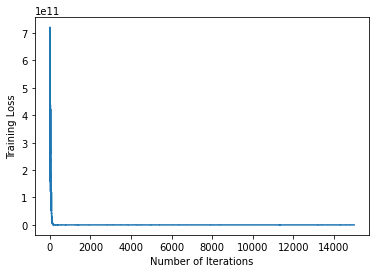

In [19]:
plt.plot(train_loss)
plt.xlabel("Number of Iterations")
plt.ylabel("Training Loss")

In [20]:
predictions = model(features)
r2 = R2Score(num_outputs=2)
price = price[:,None]
print("The r2 score for the model is ",r2(predictions,price))

The r2 score for the model is  tensor(0.3291, grad_fn=<SqueezeBackward0>)


In [21]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

linear.weight tensor([[ 3.6535e+00,  2.0156e+00,  2.4312e+00,  3.6558e+00,  1.9846e+00,
          6.0393e+00, -1.3550e-01,  1.0075e-03,  2.7205e-03,  3.1773e+00,
          2.5434e+00,  7.1393e-01]])
linear.bias tensor([4.2972])
